### This is the definitive version for producing CESM LE timeseries

In [1]:
import numpy as np
import pandas as pd
import xarray as xy
import string
from copy import deepcopy
import os.path
import matplotlib.pyplot as plt
from time import time

from constants import * #<= my defined global variables

%matplotlib inline

In [2]:
def getFileInfo(dataDir,fileNameSplitter='_',fileNamePos=2):
    def justDataFiles(path=None):
        for f in os.listdir(path):
            if ('r1i1p1_21' not in f) and ('r1i1p1_22' not in f) and ('.nc' in f) and \
                ('.106.' not in f) and ('.107.' not in f) :
                yield f
            
    files = [x for x in justDataFiles(dataDir)]  
    files.sort()

    #make a list of the model names in this file list
    modelNames = []
    for oneFile in files:
        justFileName = str.split(oneFile,'/')[-1]
        #print justFileName
        justEnsMemNum = str.split(justFileName,fileNameSplitter)[fileNamePos]
        #print justEnsMemNum
        modelNames.append(justEnsMemNum)
    modelNames = list(set(modelNames))

    #make a dictionary of all the files that go with each model
    keyvaluepairs = []
    for model in modelNames:
        #uniqueModelName = ''.join([model,fileNameSplitter])
        oneModelFileList = []
        for oneFile in files:
            justFileName = str.split(oneFile,'/')[-1]
            justEnsMemNum = str.split(justFileName,fileNameSplitter)[fileNamePos]
            if model == justEnsMemNum:
            #if uniqueModelName in oneFile:
                oneModelFileList.append(oneFile)
        tupleOfKeyValue = (model,oneModelFileList)
        keyvaluepairs.append(tupleOfKeyValue)

    fileDict = dict(keyvaluepairs)
    
    return fileDict

In [3]:
myDateTimeIndex1 = []
endDay = [31,28,31,30,31,30,31,31,30,31,30,31]
endMonth=12
for year in np.arange(1850,2101,1):
    for month in np.arange(1,endMonth+1,1):
        day=1
        oneDateTime = pd.datetime(year,month,day)
        myDateTimeIndex1.append(oneDateTime)            
myDateTimeIndex1 = pd.DatetimeIndex(myDateTimeIndex1)

myDateTimeIndex2to40 = []
for year in np.arange(1920,2101,1):
    for month in np.arange(1,endMonth+1,1):
        day=1
        oneDateTime = pd.datetime(year,month,day)
        myDateTimeIndex2to40.append(oneDateTime)            
myDateTimeIndex2to40 = pd.DatetimeIndex(myDateTimeIndex2to40)

myDateTimeIndexRCP45 = []
for year in np.arange(1920,2081,1):
    for month in np.arange(1,endMonth+1,1):
        day=1
        oneDateTime = pd.datetime(year,month,day)
        myDateTimeIndexRCP45.append(oneDateTime)            
myDateTimeIndexRCP45 = pd.DatetimeIndex(myDateTimeIndexRCP45)

myDateTimeIndexRCP45_1 = []
for year in np.arange(1850,2081,1):
    for month in np.arange(1,endMonth+1,1):
        day=1
        oneDateTime = pd.datetime(year,month,day)
        myDateTimeIndexRCP45_1.append(oneDateTime)            
myDateTimeIndexRCP45_1 = pd.DatetimeIndex(myDateTimeIndexRCP45_1)


In [4]:
def fix_my_data(ds):
    return ds[field].squeeze().to_dataset(name=field)

def readDataCESMLE(fileName,field):
    dataOneEnsMem = xy.open_mfdataset(fileName,preprocess=fix_my_data,decode_times=False) 
    isFirstOne = False
    for oneFile in fileName:
        if '1850' in oneFile:
            isFirstOne = True
    if isFirstOne:
        if 'rcp45' in fileName[0]:
            myDateTimeIndex = myDateTimeIndexRCP45_1
        else:    
            myDateTimeIndex = myDateTimeIndex1
    elif 'rcp45' in fileName[0]:
        myDateTimeIndex = myDateTimeIndexRCP45
    else:
        myDateTimeIndex = myDateTimeIndex2to40
    lon = deepcopy(dataOneEnsMem['lon'])
    lat = deepcopy(dataOneEnsMem['lat'])
    myData = xy.DataArray(deepcopy(dataOneEnsMem[field].squeeze()), coords=[myDateTimeIndex,lat,lon],dims=['time','lat','lon'])
    dataOneEnsMem.close()
    
    return myData

#get CESM weights, just once
temp = xy.open_dataset(weightFileCESM) #filename in constants.py
weightsCESM = deepcopy(temp['gw'])
temp.close()

In [5]:
def getAreaAvg(data,bounds,weights,landFrac): 

    weightedMean = 0.0
    weightTotal = 0.0
    
    areaSubset = data.sel(lon=slice(bounds.lonMin,bounds.lonMax),lat=slice(bounds.latMin,bounds.latMax)) 
    if excludeOcean:
        landFrac = landFrac.sel(lon=slice(bounds.lonMin,bounds.lonMax),lat=slice(bounds.latMin,bounds.latMax))
        areaSubset = areaSubset.where(landFrac>0.5)
    
    useCosLat = False
    try:
        if len(weights.dims)==2:
            weightsSubset = weights.sel(lon=slice(bounds.lonMin,bounds.lonMax),lat=slice(bounds.latMin,bounds.latMax))
            weightedMean = (areaSubset * weightsSubset).sum('lat').sum('lon')
        elif len(weights.dims)==1:
            weightsSubset = weights.sel(lat=slice(bounds.latMin,bounds.latMax))
            weightedMean = (areaSubset.mean('lon') * np.asarray(weightsSubset)).sum('lat')
    except:
        #try *not* using the weights from the files, which might need to be updated
        useCosLat = True
        print "an exception!"
             
    if useCosLat:
        weightsSubset = np.cos(np.deg2rad(areaSubset.lat))
        weightedMean = (areaSubset.mean('lon') * np.asarray(weightsSubset)).sum('lat')
        
    weightTotal = weightsSubset.sum()
    return weightedMean/np.double(weightTotal)

def convertPrecipUnits(dataVsTime, startingFrom=''): # converts to mm/day                                                                                                                       
    if startingFrom == 'm/s':
        return dataVsTime * 1000.0 * 60.0 * 60.0 * 24.0
    else: #default for CMIP5                                                                                                                           
        return dataVsTime * 60.0*60.0*24.0

In [6]:
def getOneFile(filename,field,bounds,frequency='monthly'):
    
    oneEnsMem = readDataCESMLE(filename,field)
    
    landFracFileName = 'b.e11.B20TRC5CNBDRD.f09_g16.'+filename[0].split('.')[4]+'.cam.h0.LANDFRAC.'+filename[0].split('.')[8]+'.nc'
    lf = xy.open_dataset(landFracCESM+landFracFileName)
    landFrac = deepcopy(lf['LANDFRAC'].isel(time=0))
    landFrac.drop('time')
    lf.close()
        
    timeSeries = getAreaAvg(oneEnsMem,bounds,weightsCESM,landFrac).to_series() 
    if field == 'PRECT':
        timeSeries = convertPrecipUnits(timeSeries,'m/s')
        
    timeSeries.index = timeSeries.index.to_period(freq='M') 
    
    return timeSeries

In [7]:
def getOneModelAllFiles(dataDir,fileList,field,bounds,fileNameSplitter='_',fileNamePos=2):
    justFileName = str.split(fileList[0],'/')[-1]
    justModelName = str.split(justFileName,fileNameSplitter)[fileNamePos]
    timeSeries = getOneFile([dataDir+filename for filename in fileList],field,bounds)
    
    timeSeries.name = justModelName
    to_return = pd.DataFrame(timeSeries)
    
    #This last bit is necessary because at least one file has duplicate rows, probably from ncrcatting together
    #more than one version of the same file. The values in the duplicate rows are not all identical.
    to_return = to_return.reset_index().drop_duplicates(subset='time',keep='last').set_index('time')
    to_return = to_return.sort_index()
    #--------------
    return to_return


## Do all regions, using PRECT or TS data

In [8]:
fileNameSplitter = '.'
fileNamePos = 4
fields = ['PRECT','TS']
excludeOcean = True

for scenario in scenariosLE:
    for field in fields:
        #edit 'dataDir' to reflect your directory structure:
        dataDir = ''.join([dataDirCESM,scenario,'/monthly/',field,'/']) 
        fileDict = getFileInfo(dataDir,fileNameSplitter,fileNamePos)
        
        # regionBounds is a dictionary defined as a global variable in constants.py
        for regionKey in regionBounds:
            if regionKey != 'global':
                excludeOcean = True
            else:
                excludeOcean = False
            time0 = time()
            allData = pd.DataFrame()
            allData = pd.concat([getOneModelAllFiles(dataDir,fileDict[model],field,regionBounds[regionKey],fileNameSplitter,fileNamePos) for model in fileDict.keys()],axis=1)            
            if excludeOcean:
                outFile = ''.join(['timeSeries/timeSeriesLO_',field,'_',regionKey,'_Monthly_cesmLE_',scenario,'.csv'])
            else:
                outFile = ''.join(['timeSeries/timeSeries_',field,'_',regionKey,'_Monthly_cesmLE_',scenario,'.csv'])
            allData.to_csv(outFile)
            time1 = time()
            print ' '.join([regionKey,field,scenario,'took',str(time1-time0)])

BC PRECT rcp85 took 264.51522398
global PRECT rcp85 took 232.243212938
Alaska PRECT rcp85 took 250.425082922
pnw PRECT rcp85 took 266.822729111
Cali PRECT rcp85 took 305.706973791
Baja PRECT rcp85 took 291.602379084
BC TS rcp85 took 278.852500916
global TS rcp85 took 298.978564978
Alaska TS rcp85 took 264.396551132
pnw TS rcp85 took 297.447539806
Cali TS rcp85 took 247.524595022
Baja TS rcp85 took 353.577697992


## Double check difference in time series with and without masking out ocean grid cells:

In [69]:
scenario = 'rcp85'
field = 'PRECT'
dataDir = ''.join([dataDirCESM,scenario,'/monthly/',field,'/']) 
fileDict = getFileInfo(dataDir,fileNameSplitter,fileNamePos)
        
filenames = fileDict['002']
oneEnsMem = readDataCESMLE([dataDir+filename for filename in filenames],field)

In [70]:
landFracFileName = 'b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h0.LANDFRAC.192001-200512.nc'
lf = xy.open_dataset(landFracCESM+landFracFileName)
landFrac = deepcopy(lf['LANDFRAC'].isel(time=0))
landFrac.drop('time')
lf.close()

In [71]:
weights = weightsCESM

In [82]:
bounds = regionBounds['Baja']
areaSubset = oneEnsMem.sel(lon=slice(bounds.lonMin,bounds.lonMax),lat=slice(bounds.latMin,bounds.latMax)) 
weightsSubset = weights.sel(lat=slice(bounds.latMin,bounds.latMax))
weightedMean = (areaSubset.mean('lon') * np.asarray(weightsSubset)).sum('lat')

landFracSubset = landFrac.sel(lon=slice(bounds.lonMin,bounds.lonMax),lat=slice(bounds.latMin,bounds.latMax))
areaSubset = areaSubset.where(landFracSubset>0.5)
weightedMean2 = (areaSubset.mean('lon') * np.asarray(weightsSubset)).sum('lat')

array([[ 1.        ,  0.97968322],
       [ 0.97968322,  1.        ]])

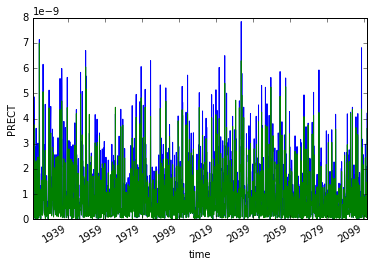

In [83]:
weightedMean.plot()
weightedMean2.plot()

np.corrcoef(weightedMean,weightedMean2)

In [ ]:
# output a copy of allData to inspect one:
allData

## Map showing grid cells land fraction

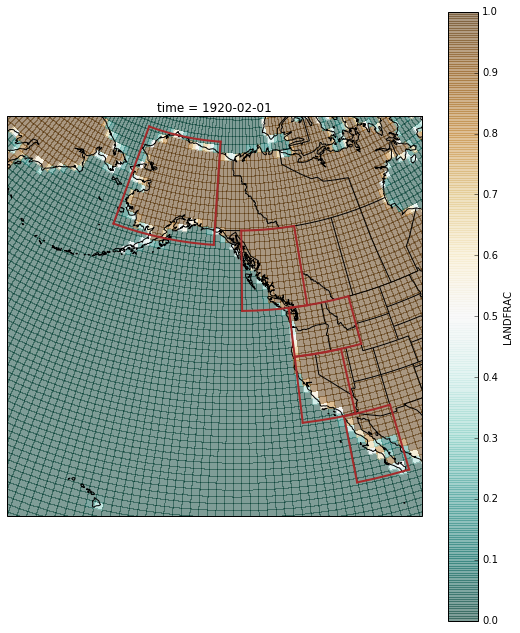

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm  #colormap

class LowerThresholdLambert(ccrs.LambertConformal):
    @property
    def threshold(self):
        return 1e3

fig = plt.figure(figsize=[9,9], frameon=True)
ax = fig.add_axes([0.08, 0.05, 0.8, 0.94], projection=LowerThresholdLambert(-135)) #LowerThresholdOrtho(-135,46))
ax.set_extent((191, 252, 20, 72),crs=ccrs.PlateCarree()) 
ax.coastlines(resolution='50m')
#ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'))
landFrac.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),cmap=cm.BrBG_r,alpha=0.5)

colors = ['brown','brown','brown','brown','brown','brown']
for i, region in enumerate(regionBounds):
    bounds = regionBounds[region]
    ax.plot([bounds.lonMin,bounds.lonMin], [bounds.latMin,bounds.latMax], color=colors[i], transform=ccrs.PlateCarree(),linewidth=2)
    ax.plot([bounds.lonMax,bounds.lonMax], [bounds.latMin,bounds.latMax], color=colors[i], transform=ccrs.PlateCarree(),linewidth=2)
    ax.plot([bounds.lonMin,bounds.lonMax], [bounds.latMin,bounds.latMin], color=colors[i], transform=ccrs.PlateCarree(),linewidth=2)
    ax.plot([bounds.lonMin,bounds.lonMax], [bounds.latMax,bounds.latMax], color=colors[i], transform=ccrs.PlateCarree(),linewidth=2)
    
fig.canvas.draw()